**ASSOCIATE MANAGER , DATA ANALYST ASSESSMENT TEST**

**SECTION B**

**Covid-19 Case prediction and Modelling**

In [2]:
# installing & loading Models

In [ ]:
pip install lazypredict shap sckit_learn pandas geopandas matplotlib shap lazypredict openpyxl

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, cohen_kappa_score, matthews_corrcoef,
    log_loss, brier_score_loss
)
from sklearn.pipeline import make_pipeline
import joblib
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [7]:
# Lazy Predict for quick benchmarking
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

## Data Collection and Preparation
ehealth Africa carried out an investigation on various factors that could determine if someone has covid-19 or not.

Data collection tools include Koboforma and clinical reports

In [13]:
# Load data from CSV file

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
file_path = 'COVID19.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# Display the first few rows of the DataFrame

In [28]:
df

,Sex,Birth Year,Chest pain,Chills or sweats,Confused or disoriented,Cough,Diarrhea,Difficulty breathing or Dyspnea,Digested blood or coffee grounds in vomit,Pain behind eyes or Sensitivity to light,...,Cough with sputum,Cough with heamoptysis,Enlarged lymph nodes,Wheezing,Skin ulcers,Inability to walk,Indrawing of chest wall,Other complications,Specify other complications,Result
0,MALE,1960.00,NO,NO,NO,YES,NO,NO,NaN,NaN,...,NO,NO,NO,NO,NO,NO,NO,0.00,Acute respiratory distress syndrome,NEGATIVE
1,MALE,1990.00,NO,NO,UNKNOWN,YES,YES,YES,NaN,NaN,...,NO,NO,NO,NO,NO,NO,NO,0.00,ARDS,NEGATIVE
2,FEMALE,1918.00,YES,YES,NaN,YES,YES,YES,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,ARDS,NEGATIVE
3,MALE,1966.00,NO,NO,NO,YES,NO,NO,NaN,NaN,...,NO,NO,NO,NO,NO,NO,NO,0.00,Diabetic,POSITIVE
4,FEMALE,2001.00,NO,NO,NO,NO,NO,NO,NaN,NaN,...,NO,NO,NO,NO,NO,NO,NO,0.00,shortness of breath,NEGATIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109922,MALE,NaN,NO,NaN,NaN,NO,NO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEGATIVE
109923,MALE,1996.00,NO,NaN,NaN,NO,NO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEGATIVE
109924,MALE,1986.00,NO,NaN,NaN,NO,NO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POSITIVE
109925,MALE,1996.00,NO,NaN,NaN,NO,NO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEGATIVE


# Exploratory Data Analysis

Data Cleaning

In [ ]:
# checking for null and empty cells
df.isna().sum()

Sex                                            2699
Birth Year                                    14964
Chest pain                                    67807
Chills or sweats                              85070
Confused or disoriented                       86800
Cough                                         67709
Diarrhea                                      67835
Difficulty breathing or Dyspnea               84987
Digested blood or coffee grounds in vomit    108530
Pain behind eyes or Sensitivity to light     108522
Bleeding from the eyes                       108530
Fatigue or general weakness                   67769
Fever                                         67698
Fluid in the lung cavity                     108523
Fluid in lung cavity in auscultation          86501
Fluid in cavity through X-Ray                 86511
Bleeding of the gums                         108530
Headache                                      67847
Joint pain or arthritis                       85097
Thorax (sore

In [ ]:
# Remove columns that are completely empty

df_cleaned = df.dropna(axis=1, how='all') # since an empty column is of no use, I had to remove them


In [ ]:
#Replacing 'NO' with 0 and 'YES' with 1 in the relevant columns

for column in df_cleaned.select_dtypes(include=['object']).columns: #Only replaces in columns with object type
    df_cleaned[column] = df_cleaned[column].replace({'NO': 0, 'YES': 1}).astype(int, errors='ignore')

In [32]:
# Converting 'Result' column to 1 for 'Positive' and 0 for 'Negative'
df_cleaned['Result'] = df_cleaned['Result'].map({'POSITIVE': 1, 'NEGATIVE': 0}).astype(int, errors='ignore')


In [ ]:
# Replace "UNKNOWN" and NaN with 0 
# - since all rows in one way or the other has empty cells remove rows with NaN was not advisable 
df_cleaned.replace("UNKNOWN", 0, inplace=True)
df_cleaned.fillna(0, inplace=True)

In [ ]:
#  df is cleaned and ready for prediction tasks and saved with a new dataframe 'df_cleaned'
print(df_cleaned.head())

      Sex  Birth Year  Chest pain  Chills or sweats  Confused or disoriented  \
0    MALE     1960.00        0.00              0.00                     0.00   
1    MALE     1990.00        0.00              0.00                     0.00   
2  FEMALE     1918.00        1.00              1.00                     0.00   
3    MALE     1966.00        0.00              0.00                     0.00   
4  FEMALE     2001.00        0.00              0.00                     0.00   

   Cough  Diarrhea  Difficulty breathing or Dyspnea  \
0   1.00      0.00                             0.00   
1   1.00      1.00                             1.00   
2   1.00      1.00                             1.00   
3   1.00      0.00                             0.00   
4   0.00      0.00                             0.00   

   Digested blood or coffee grounds in vomit  \
0                                       0.00   
1                                       0.00   
2                                       0.00

In [ ]:
# call out the clean records
df_cleaned

,Sex,Birth Year,Chest pain,Chills or sweats,Confused or disoriented,Cough,Diarrhea,Difficulty breathing or Dyspnea,Digested blood or coffee grounds in vomit,Pain behind eyes or Sensitivity to light,...,Cough with sputum,Cough with heamoptysis,Enlarged lymph nodes,Wheezing,Skin ulcers,Inability to walk,Indrawing of chest wall,Other complications,Specify other complications,Result
0,MALE,1960.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Acute respiratory distress syndrome,0.00
1,MALE,1990.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,ARDS,0.00
2,FEMALE,1918.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,ARDS,0.00
3,MALE,1966.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Diabetic,1.00
4,FEMALE,2001.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,shortness of breath,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109922,MALE,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00
109923,MALE,1996.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00
109924,MALE,1986.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1.00
109925,MALE,1996.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [ ]:
# save  out the clean records as .csv
df_cleaned.to_csv('cleaned_data.csv', index=False)

In [ ]:
# Define features and target variable

In [ ]:
#- base on literature review the following variables are major symptoms of Covid19 and where selected
# 'Chest pain', 'Chills or sweats', 'Confused or disoriented', 'Cough', 'Diarrhea', 'Difficulty breathing or Dyspnea', 'Cough with sputum', 'Cough with heamoptysis', 'Wheezing'

features = [
    'Chest pain', 'Chills or sweats', 'Confused or disoriented', 'Cough'
    , 'Diarrhea', 'Difficulty breathing or Dyspnea', 'Cough with sputum', 'Cough with heamoptysis', 'Wheezing'
]
target = 'Result'

In [ ]:
df_cleaned['Result'] = df_cleaned['Result'].astype(int)  # I Ensured that target variable is numeric
df_cleaned[features] = df_cleaned[features].astype(int)  # I Converted feature columns to numeric

In [ ]:
# Prepare feature matrix X and target vector y

In [39]:
X = df_cleaned[features]
y = df_cleaned[target]

# Feature Engineering
For the Feature engineering, Variance Inflation Factore was first perform to check for multi-coliniarity then Feature importance was carried to see how the difference variables are doing and their predictive power to the independent variable in this case covid19

In [41]:
# Calculate VIF (Variance Inflation Factor)
X_constant = sm.add_constant(X)
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
vif_df = pd.DataFrame({'Feature': ['Intercept'] + features, 'VIF': vif})
print("VIF Values:")
print(vif_df)

VIF Values:
                           Feature  VIF
0                        Intercept 1.01
1                       Chest pain 1.17
2                 Chills or sweats 1.12
3          Confused or disoriented 1.04
4                            Cough 1.29
5                         Diarrhea 1.07
6  Difficulty breathing or Dyspnea 1.23
7                Cough with sputum 1.19
8           Cough with heamoptysis 1.11
9                         Wheezing 1.00



Feature Importances:
                           Feature  Random Forest Importance  \
3                            Cough                      0.64   
5  Difficulty breathing or Dyspnea                      0.10   
6                Cough with sputum                      0.07   
4                         Diarrhea                      0.07   
0                       Chest pain                      0.06   
1                 Chills or sweats                      0.04   
2          Confused or disoriented                      0.02   
8                         Wheezing                      0.00   
7           Cough with heamoptysis                      0.00   

   Logistic Regression Coefficient  
3                             1.91  
5                             0.17  
6                             0.84  
4                             0.33  
0                             0.45  
1                             0.07  
2                             0.04  
8                             0.03  
7   

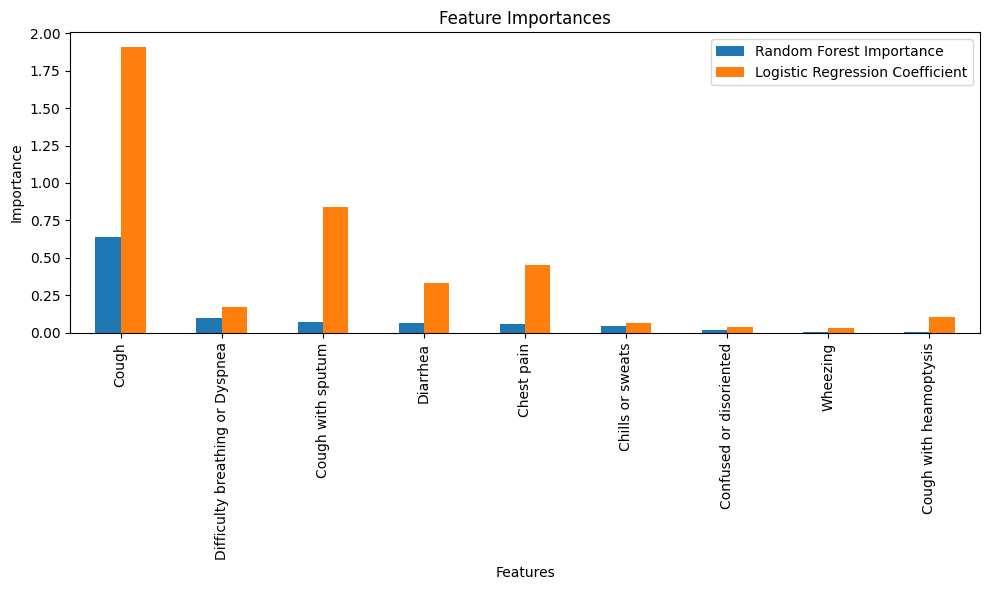

In [42]:
# Random Forest Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)
rf_importances = rf_model.feature_importances_

# Logistic Regression Coefficients
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X, y)
log_reg_coefficients = np.abs(log_reg_model.coef_[0])

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Random Forest Importance': rf_importances,
    'Logistic Regression Coefficient': log_reg_coefficients
}).sort_values(by='Random Forest Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

# Plot Feature Importances
importance_df.set_index('Feature').plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# SHAP Values for Feature Interpretability
#explainer = shap.Explainer(rf_model, X)
#shap_values = explainer(X)

# Plot SHAP summary plot
#shap.summary_plot(shap_values, X, plot_type="bar")

# Choosing Models
Using Lazy Predict, machine learning models were quickly generated using Varibles to see their perfromance and runtime. this helps to identify Models Before Tunning them for best performance

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Initialize LazyClassifier for classification task
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit the models
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the models and their results
print(models)

In [46]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.95,0.52,0.52,0.94,0.07
LinearDiscriminantAnalysis,0.95,0.52,0.52,0.94,0.10
BernoulliNB,0.96,0.50,0.50,0.94,0.08
CategoricalNB,0.96,0.50,0.50,0.94,0.09
Perceptron,0.96,0.50,0.50,0.94,0.20
QuadraticDiscriminantAnalysis,0.96,0.50,0.50,0.94,0.13
AdaBoostClassifier,0.96,0.50,0.50,0.94,1.08
BaggingClassifier,0.96,0.50,0.50,0.94,0.32
CalibratedClassifierCV,0.96,0.50,0.50,0.94,0.51


# Model Training and Evaluation

In [ ]:
# Split data into training (80%)and testing sets (20%)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [ ]:
# Define models

In [48]:
models = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': make_pipeline(StandardScaler(), SVC(probability=True)),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [ ]:
# Directory to save models

In [49]:
model_save_path = './models'
os.makedirs(model_save_path, exist_ok=True)

In [ ]:
# Function to plot ROC curve and calculate AUC

In [51]:
def plot_roc_auc(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

    return auc

In [ ]:
# Dictionary to store performance metrics

In [52]:
model_performance = {}

In [ ]:
# Train, evaluate, and save models

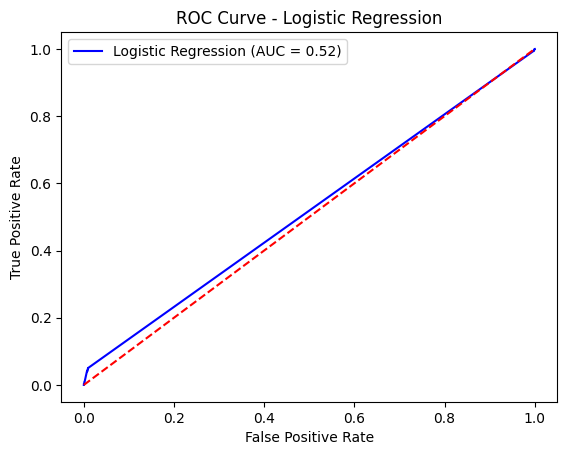

Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21112
           1       1.00      0.00      0.00       874

    accuracy                           0.96     21986
   macro avg       0.98      0.50      0.49     21986
weighted avg       0.96      0.96      0.94     21986

Confusion Matrix:
[[21112     0]
 [  874     0]]
--------------------------------------------------
Model saved to: ./models\Logistic_Regression.pkl


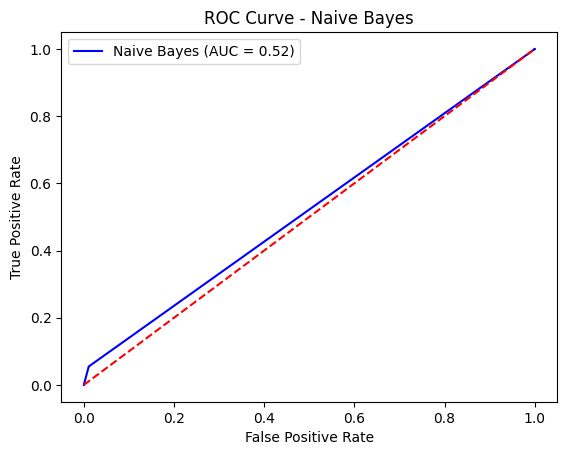

Model: Naive Bayes
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.00      0.00     21112
           1       0.04      1.00      0.08       874

    accuracy                           0.04     21986
   macro avg       0.49      0.50      0.04     21986
weighted avg       0.90      0.04      0.00     21986

Confusion Matrix:
[[   15 21097]
 [    1   873]]
--------------------------------------------------
Model saved to: ./models\Naive_Bayes.pkl


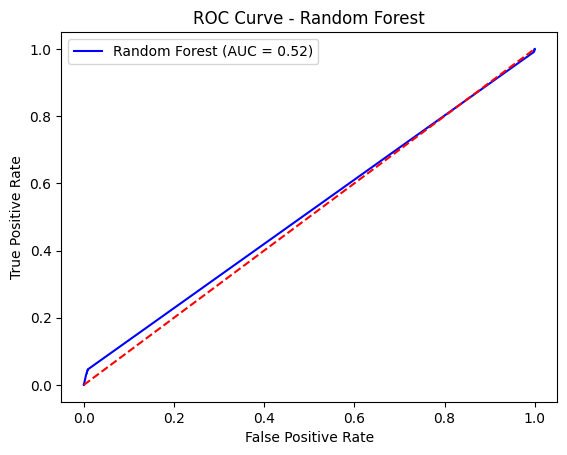

Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21112
           1       1.00      0.00      0.00       874

    accuracy                           0.96     21986
   macro avg       0.98      0.50      0.49     21986
weighted avg       0.96      0.96      0.94     21986

Confusion Matrix:
[[21112     0]
 [  874     0]]
--------------------------------------------------
Model saved to: ./models\Random_Forest.pkl


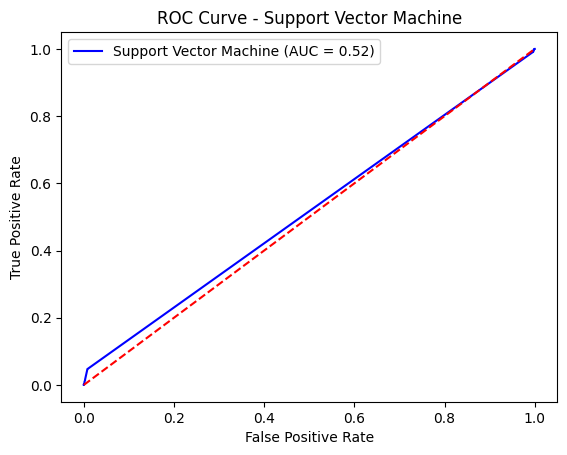

Model: Support Vector Machine
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21112
           1       1.00      0.00      0.00       874

    accuracy                           0.96     21986
   macro avg       0.98      0.50      0.49     21986
weighted avg       0.96      0.96      0.94     21986

Confusion Matrix:
[[21112     0]
 [  874     0]]
--------------------------------------------------
Model saved to: ./models\Support_Vector_Machine.pkl


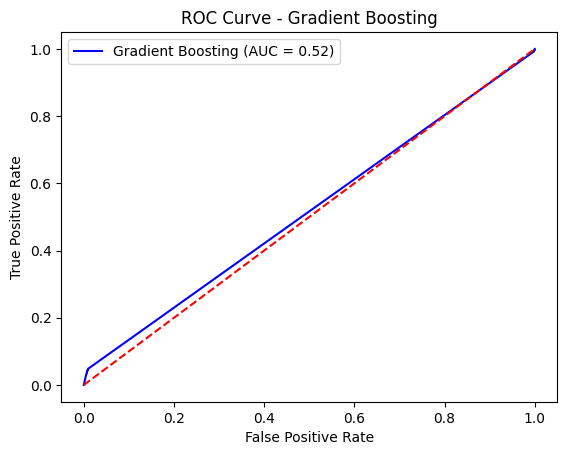

Model: Gradient Boosting
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21112
           1       1.00      0.00      0.00       874

    accuracy                           0.96     21986
   macro avg       0.98      0.50      0.49     21986
weighted avg       0.96      0.96      0.94     21986

Confusion Matrix:
[[21112     0]
 [  874     0]]
--------------------------------------------------
Model saved to: ./models\Gradient_Boosting.pkl


In [53]:

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability predictions for log loss and Brier score

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_prob)
    brier = brier_score_loss(y_test, y_pred_prob)
    cv_accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

    auc = plot_roc_auc(model, X_test, y_test, name) if hasattr(model, "predict_proba") else None

    model_performance[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Cohen Kappa': kappa,
        'MCC': mcc,
        'Log Loss': logloss,
        'Brier Score': brier,
        'CV Accuracy': cv_accuracy
    }

    print(f"Model: {name}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

    model_path = os.path.join(model_save_path, f'{name.replace(" ", "_")}.pkl')
    joblib.dump(model, model_path)
    print(f"Model saved to: {model_path}")
    print("=" * 50)

In [ ]:
# Compare the performance of all models

In [54]:
comparison_df = pd.DataFrame(model_performance).T
print("\nComparison of Model Performance:")
print(comparison_df)


Comparison of Model Performance:
                        Accuracy  Precision  Recall  F1 Score  AUC  \
Logistic Regression         0.96       0.96    0.96      0.94 0.52   
Naive Bayes                 0.04       0.90    0.04      0.00 0.52   
Random Forest               0.96       0.96    0.96      0.94 0.52   
Support Vector Machine      0.96       0.96    0.96      0.94 0.52   
Gradient Boosting           0.96       0.96    0.96      0.94 0.52   

                        Cohen Kappa   MCC  Log Loss  Brier Score  CV Accuracy  
Logistic Regression            0.00  0.00      0.17         0.04         0.96  
Naive Bayes                   -0.00 -0.00      7.80         0.96         0.22  
Random Forest                  0.00  0.00      0.17         0.04         0.96  
Support Vector Machine         0.00  0.00      0.17         0.04         0.96  
Gradient Boosting              0.00  0.00      0.17         0.04         0.96  


# Model Performance Evaluation

In [ ]:
# Identify the best-performing model based on F1 Score

In [55]:
best_model = comparison_df['F1 Score'].idxmax()
print(f"\nBest-performing model: {best_model} based on F1 Score")


Best-performing model: Logistic Regression based on F1 Score


In [ ]:
# ANOVA-like test for Logistic Regression

In [56]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print("\nLogistic Regression Summary (ANOVA-like):")
print(logit_model.summary())

         Current function value: 0.163282
         Iterations: 35

Logistic Regression Summary (ANOVA-like):
                           Logit Regression Results                           
Dep. Variable:                 Result   No. Observations:                87941
Model:                          Logit   Df Residuals:                    87931
Method:                           MLE   Df Model:                            9
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.01465
Time:                        15:26:49   Log-Likelihood:                -14359.
converged:                      False   LL-Null:                       -14573.
Covariance Type:            nonrobust   LLR p-value:                 2.351e-86
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -3.2481      0.018   -18

The Best Model is now ready for Trail using either covid19_flask_app.py or covid19_streamlit_app.py